这里显示异常检测

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import io as spio

参数估计函数和多元高斯分布函数

In [2]:
def estimateGaussian(X):
    mu = np.mean(X, axis=0)  # axis=0表示列，每列的均值
    sigma2 = np.var(X,axis=0)  # 求每列的方差
    return mu,sigma2


def multivariateGaussian(X,mu,Sigma2):
    k = len(mu)
    if (Sigma2.shape[0]>1):
        Sigma2 = np.diag(Sigma2)
    '''多元高斯分布函数'''    
    X = X-mu
    argu = (2*np.pi)**(-k/2)*np.linalg.det(Sigma2)**(-0.5)
    p = argu*np.exp(-0.5*np.sum(np.dot(X,np.linalg.inv(Sigma2))*X,axis=1))  # axis表示每行
    return p

优化

In [3]:
def selectThreshold(yval,pval):
    '''初始化所需变量'''
    bestEpsilon = 0.
    bestF1 = 0.
    F1 = 0.
    step = (np.max(pval)-np.min(pval))/1000
    '''计算'''
    for epsilon in np.arange(np.min(pval),np.max(pval),step):
        cvPrecision = pval < epsilon
        tp = np.sum((cvPrecision == 1) & (yval == 1)).astype(float)  # sum求和是int型的，需要转为float
        fp = np.sum((cvPrecision == 1) & (yval == 0)).astype(float)
        fn = np.sum((cvPrecision == 1) & (yval == 0)).astype(float)
        precision = tp/(tp+fp)  # 精准度
        recision = tp/(tp+fn)   # 召回率
        F1 = (2*precision*recision)/(precision+recision)  # F1Score计算公式
        if F1 > bestF1:  # 修改最优的F1 Score
            bestF1 = F1
            bestEpsilon = epsilon
    return bestEpsilon,bestF1

可视化

In [4]:
def display_2d_data(X,marker):
    plt.plot(X[:,0],X[:,1],marker)
    plt.axis('square')
    return plt

def visualizeFit(X,mu,sigma2):
    x = np.arange(0, 36, 0.5)  # 0-36，步长0.5
    y = np.arange(0, 36, 0.5)
    X1,X2 = np.meshgrid(x,y)  # 要画等高线，所以meshgird
    Z = multivariateGaussian(np.hstack((X1.reshape(-1,1),X2.reshape(-1,1))), mu, sigma2)  # 计算对应的高斯分布函数
    Z = Z.reshape(X1.shape)  # 调整形状
    plt.plot(X[:,0],X[:,1],'bx')
    
    if np.sum(np.isinf(Z).astype(float)) == 0:   # 如果计算的为无穷，就不用画了
        # 画等高线，Z的值在10.**np.arange(-20, 0, 3)
        CS = plt.contour(X1,X2,Z,10.**np.arange(-20, 0, 3),color='black',linewidth=.5)
        #plt.clabel(CS)
    plt.show()

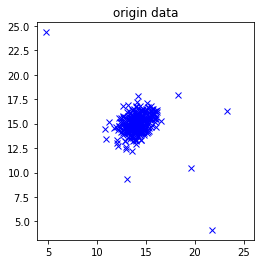

C:\Users\Techik\Anaconda2\envs\gluon\lib\site-packages\matplotlib\contour.py:967: UserWarning: The following kwargs were not used by contour: 'color', 'linewidth'
  s)


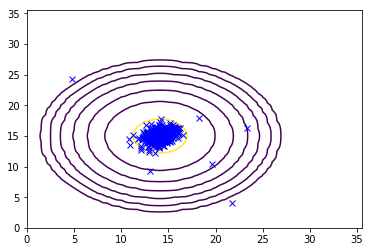

C:\Users\Techik\Anaconda2\envs\gluon\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
C:\Users\Techik\Anaconda2\envs\gluon\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


在CV上得到的最好的epsilon是：8.990853e-05
对应的F1Score值为：0.029316


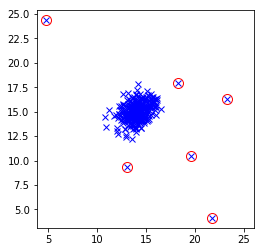

In [6]:
data = spio.loadmat('../data/7-anomaly_detection/data1.mat')
X = data['X']
plt = display_2d_data(X, 'bx')
plt.title("origin data")
plt.show()
'''多元高斯分布函数，并可视化拟合的边界'''
mu,sigma2 = estimateGaussian(X)         # 参数估计（求均值和方差）
#print mu,sigma2
p = multivariateGaussian(X,mu,sigma2)   # 多元高斯分布函数
#print p
visualizeFit(X,mu,sigma2)  # 显示图像

'''选择异常点（在交叉验证CV上训练得到最好的epsilon）'''
Xval = data['Xval']
yval = data['yval']   # y=1代表异常
pval = multivariateGaussian(Xval, mu, sigma2)  # 计算CV上的概率密度值
epsilon,F1 = selectThreshold(yval,pval)       # 选择最优的epsilon临界值
print(u'在CV上得到的最好的epsilon是：%e' % epsilon)
print(u'对应的F1Score值为：%f' % F1)
outliers = np.where(p < epsilon)  # 找到小于临界值的异常点，并作图
plt.plot(X[outliers,0],X[outliers,1],'o',markeredgecolor='r',markerfacecolor='w',markersize=10.)
plt = display_2d_data(X, 'bx')
plt.show()
